# Object Detector Training and Evaluation

# TODO
- cleanup some stuff
- add training or training explanation

In [2]:
import os
os.chdir('/app/Pogona_realtime/Arena')

# Imports

In [3]:
import cv2 as cv
import numpy as np
from glob import glob
from tqdm.auto import tqdm
import pandas as pd
from time import time
import imp
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import json

from Prediction import detector
from Prediction import dataset
from Prediction import train_eval

In [9]:
imp.reload(detector)
imp.reload(dataset)
imp.reload(train_eval)

<module 'Prediction.train_eval' from '/app/Pogona_realtime/Arena/Prediction/train_eval.py'>

# Load Data

In [10]:
all_df = dataset.collect_data(data_sources={'detections': True, 'timestamps': True, 'dlc': False, 'touches': True})

110 trials loaded


In [11]:
trials = all_df.index.unique()

# Generate a test-set for detector evaluation

In [1]:
input_labels = ['x1', 'y1', 'x2', 'y2']
output_labels = ['x1', 'y1', 'x2', 'y2']
inp_seq_len = 20
out_seq_len = 20

In [13]:
INF_P = 9999999

mask_dict = {
    'fl_dist': [0, INF_P, True, True], # min, max, mask_X, mask_Y
    'speed': [0, INF_P, True, True],
    'std': [0.0, INF_P, [0,1]],
    'corr': [0.0, 1.0, True, True],
    'zgzg': [0.0, 1.5, True, True],
    'keep_prob': 0.0
}

mask_fn = train_eval.keep_mask(train_eval.compose_masks(mask_fns=[
    train_eval.mask_fl_dist(*mask_dict['fl_dist']),
    train_eval.mask_speed(*mask_dict['speed']),
    train_eval.mask_std(*mask_dict['std']),
    train_eval.mask_corr(*mask_dict['corr']),
    train_eval.mask_zgzg(*mask_dict['zgzg'])
    ], invert=False),keep_prob=mask_dict['keep_prob'])

In [14]:
def save_video_frames(vid_path, output_dir, name, frame_idxs):
    vcap = cv.VideoCapture(vid_path)
    
    for i in frame_idxs:
        vcap.set(cv.CAP_PROP_POS_FRAMES, i)
        ret, frame = vcap.read()
        cv.imwrite(os.path.join(output_dir, f"{name}_{i}.jpg"), frame)

In [15]:
seq_len = inp_seq_len + out_seq_len
output_dir = '../yolo_eval_frames'
choice_freq = 0.04

In [45]:
for trial in trials:
    frame_idxs = set()
    vid_path = dataset.get_trial_video_path(trial)
    X_trial, Y_trial = train_eval.trial_to_samples(all_df.loc[trial], 
                                                   input_labels,
                                                   output_labels,
                                                   inp_seq_len,
                                                   out_seq_len,
                                                   keep_nans=True)    
    trial_mask = mask_fn(X_trial, Y_trial)
    mask_idxs = np.argwhere(trial_mask).reshape(-1)
    for i in mask_idxs:
        frame_idxs.update(range(i, i+seq_len))

    sample_idxs = np.random.choice(np.array(list(frame_idxs)), int(choice_freq * len(frame_idxs)), replace=False)
    print(f"{trial}: Saving {len(sample_idxs)}/{len(frame_idxs)}")
    save_video_frames(vid_path, output_dir, trial, sample_idxs)

feeding_20200830-115520_None: Saving 20/515
feeding_20200830-120813_None: Saving 50/1259
feeding_4_20200830-121143_None: Saving 68/1705
feeding_4_20200830-122515_None: Saving 31/789
feeding_4_20200830-125531_None: Saving 101/2531
feeding_4_20200830-125905_None: Saving 62/1574
feeding_4_screen_20200830-130446_None: Saving 112/2820
feeding_5_20200830-131348_None: Saving 23/582
line_20200803T081429_trial1: Saving 18/452
line_20200803T081735_trial1: Saving 0/0
line_20200803T082002_trial1: Saving 0/0
fast_line_20200803T082414_trial1: Saving 15/378
fast_line_20200803T082724_trial1: Saving 2/56
circle_20200803T084227_trial1: Saving 26/658
circle_20200803T084227_trial2: Saving 2/57
circle_20200803T084529_trial1: Saving 7/193
circle_20200803T084529_trial2: Saving 13/336
fast_cockroach_20200803T085738_trial1: Saving 67/1677
circle_20200803T090234_trial1: Saving 40/1013
circle_20200803T090615_trial1: Saving 59/1483
circle_20200803T091639_trial1: Saving 56/1402
circle_20200803T092248_trial1: Savin

# Evaluate detector

## Detect saved images and store in dataframe, csv

In [16]:
output_dir = '../yolo_eval_frames'
im_paths = sorted(glob(os.path.join(output_dir, "*.jpg")))

In [17]:
det = detector.Detector_v4(conf_thres=0.8, nms_thres=0.5)

Detector initiated successfully


In [18]:
det_df = pd.DataFrame(columns=['filename', 'run_time_ms', 'x1', 'y1', 'x2', 'y2', 'confidence'])

In [19]:
i = 0

for im_path in tqdm(im_paths):
    im = cv.imread(im_path)
    start_time = time()
    ds = det.detect_image(im)
    run_time = (time() - start_time) * 1000
    if ds is not None:
        for d in ds:
            det_df.loc[i] = [im_path, run_time] + d.tolist()
    else:
        det_df.loc[i] = [im_path, run_time] + [np.nan]*5
    i+=1

In [20]:
det_df

,filename,run_time_ms,x1,y1,x2,y2,confidence
0,../yolo_eval_frames/beetle_fast_line_20200830T...,15.825510,625.657848,851.224224,712.196766,951.640766,0.997396
1,../yolo_eval_frames/beetle_fast_line_20200830T...,15.609026,755.103867,860.310383,846.916153,955.088421,0.996655
2,../yolo_eval_frames/beetle_fast_line_20200830T...,15.657425,757.308044,859.355007,848.846741,954.960178,0.995998
3,../yolo_eval_frames/beetle_fast_line_20200830T...,15.647888,745.637936,844.821400,851.305912,937.720470,0.995361
4,../yolo_eval_frames/beetle_fast_line_20200830T...,15.683889,755.912395,843.719917,856.915119,937.325737,0.995899
...,...,...,...,...,...,...,...
1205,../yolo_eval_frames/worm_line_20200830T122932_...,15.084267,677.899914,651.165081,771.233997,725.281208,0.998050
1206,../yolo_eval_frames/worm_line_20200830T122932_...,14.217377,601.146206,646.172234,712.522861,729.447884,0.996085
1207,../yolo_eval_frames/worm_line_20200830T122932_...,14.372349,663.051109,665.764328,755.521400,754.957718,0.996884
1208,../yolo_eval_frames/worm_line_20200830T122932_...,14.345169,661.499649,667.013939,753.378281,752.545143,0.995642


## Latency Distribution

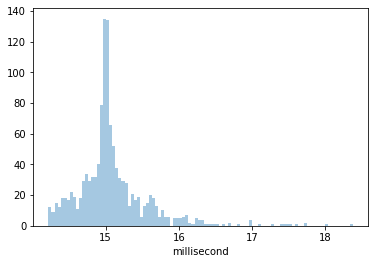

In [21]:
sns.distplot(det_df['run_time_ms'], bins=100, kde=False)
plt.xlabel('millisecond')
plt.savefig('../experiments_plots/yolo_timings.png', dpi=200)
None

In [22]:
det_df['run_time_ms'].mean()

15.086151745693742

### Save detections dataframe

In [87]:
det_df.to_csv(os.path.join(output_dir, "detections.csv"))

### Reload detections from file

In [5]:
output_dir = '../yolo_eval_frames'
det_df = pd.read_csv(os.path.join(output_dir, "detections.csv"), index_col=[0])
det_df = det_df.sort_values('filename')
det_df.reset_index(drop=True)

,filename,run_time_ms,x1,y1,x2,y2,confidence
0,../yolo_eval_frames/beetle_fast_line_20200830T...,13.516903,625.657848,851.224224,712.196766,951.640766,0.997396
1,../yolo_eval_frames/beetle_fast_line_20200830T...,13.870955,755.103867,860.310383,846.916153,955.088421,0.996655
2,../yolo_eval_frames/beetle_fast_line_20200830T...,13.391018,757.308044,859.355007,848.846741,954.960178,0.995998
3,../yolo_eval_frames/beetle_fast_line_20200830T...,13.277769,745.637936,844.821400,851.305912,937.720470,0.995361
4,../yolo_eval_frames/beetle_fast_line_20200830T...,13.500690,755.912395,843.719917,856.915119,937.325737,0.995899
...,...,...,...,...,...,...,...
1205,../yolo_eval_frames/worm_line_20200830T122932_...,13.104916,677.899914,651.165081,771.233997,725.281208,0.998050
1206,../yolo_eval_frames/worm_line_20200830T122932_...,13.064623,601.146206,646.172234,712.522861,729.447884,0.996085
1207,../yolo_eval_frames/worm_line_20200830T122932_...,13.101578,663.051109,665.764328,755.521400,754.957718,0.996884
1208,../yolo_eval_frames/worm_line_20200830T122932_...,13.213873,661.499649,667.013939,753.378281,752.545143,0.995642


## Read Label Files

In [6]:
label_dir = '../yolo_eval_labels'
label_paths = glob(os.path.join(label_dir, "*.txt"))
label_paths.sort()

im_width = 1440
im_height = 1080

det_df['target_x1'] = np.nan
det_df['target_y1'] = np.nan
det_df['target_x2'] = np.nan
det_df['target_y2'] = np.nan

for i, label_path in enumerate(tqdm(label_paths)):
    with open(label_path, "r") as f:
        s = f.readline()
        target = [float(e) for e in s.split(" ")[1:]]
        target[0] *= im_width
        target[1] *= im_height
        target[2] *= im_width
        target[3] *= im_height
        target = detector.centwh_to_xyxy(target)
        det_df.iloc[i, det_df.columns.get_loc('target_x1')] = target[0]
        det_df.iloc[i, det_df.columns.get_loc('target_y1')] = target[1]
        det_df.iloc[i, det_df.columns.get_loc('target_x2')] = target[2]
        det_df.iloc[i, det_df.columns.get_loc('target_y2')] = target[3]

In [7]:
det_df

,filename,run_time_ms,x1,y1,x2,y2,confidence,target_x1,target_y1,target_x2,target_y2
1209,../yolo_eval_frames/beetle_fast_line_20200830T...,13.516903,625.657848,851.224224,712.196766,951.640766,0.997396,619.00056,846.99972,711.00072,951.99948
1204,../yolo_eval_frames/beetle_fast_line_20200830T...,13.870955,755.103867,860.310383,846.916153,955.088421,0.996655,744.00048,856.99998,843.00048,957.00042
1207,../yolo_eval_frames/beetle_fast_line_20200830T...,13.391018,757.308044,859.355007,848.846741,954.960178,0.995998,745.99920,858.00006,848.99952,958.00050
1203,../yolo_eval_frames/beetle_fast_line_20200830T...,13.277769,745.637936,844.821400,851.305912,937.720470,0.995361,733.00032,845.00010,850.99968,941.00022
1208,../yolo_eval_frames/beetle_fast_line_20200830T...,13.500690,755.912395,843.719917,856.915119,937.325737,0.995899,743.99976,840.99978,858.99960,937.99998
...,...,...,...,...,...,...,...,...,...,...,...
1182,../yolo_eval_frames/worm_line_20200830T122932_...,13.104916,677.899914,651.165081,771.233997,725.281208,0.998050,672.00048,649.00008,775.00080,734.00040
1180,../yolo_eval_frames/worm_line_20200830T122932_...,13.064623,601.146206,646.172234,712.522861,729.447884,0.996085,600.00048,645.99984,708.00048,730.00008
1181,../yolo_eval_frames/worm_line_20200830T122932_...,13.101578,663.051109,665.764328,755.521400,754.957718,0.996884,661.99968,666.99936,756.00000,753.99984
1183,../yolo_eval_frames/worm_line_20200830T122932_...,13.213873,661.499649,667.013939,753.378281,752.545143,0.995642,661.99968,665.99928,751.99968,751.99968


# IoU Metric Evaluation

In [18]:
plots_dir = '../experiments_plots'

dets = det_df[['x1', 'y1', 'x2', 'y2']].to_numpy()
targets = det_df[['target_x1', 'target_y1', 'target_x2', 'target_y2']].to_numpy()
ious = detector.bbox_iou(torch.from_numpy(dets), torch.from_numpy(targets))

In [9]:
det_df['IoU'] = ious


In [204]:
det_df.to_csv(os.path.join(output_dir, "yolo_eval.csv"), index=False)

In [82]:
det_df = pd.read_csv(os.path.join(output_dir, "yolo_eval.csv"))

In [10]:
ious.mean()

tensor(0.8641, dtype=torch.float64)

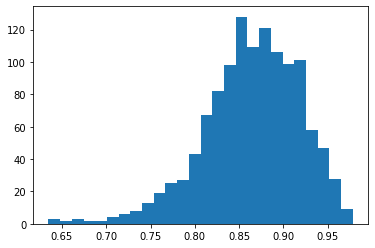

In [11]:
plt.hist(det_df['IoU'], bins='fd')
plt.savefig(os.path.join(plots_dir, "iou_histogram.png"), dpi=300)

## Sample Images from the IoU Distribution

In [12]:
sorted_df = det_df.sort_values('IoU')

In [13]:
i = 95 * sorted_df.shape[0] // 100
sorted_df.iloc[i]['IoU']

0.9441712644679934

In [14]:
def plot_row(row):
    img = cv.imread(row.filename)
    fig,ax = plt.subplots(1, figsize=(15,15))
    ax.imshow(img)
    ax.add_patch(patches.Rectangle((row.target_x1,row.target_y1),row.target_x2-row.target_x1, row.target_y2-row.target_y1,linewidth=1,edgecolor='g',facecolor='none'))
    ax.add_patch(patches.Rectangle((row.x1,row.y1),row.x2-row.x1, row.y2-row.y1,linewidth=1,edgecolor='r',facecolor='none'))

### 5% Quantile Image

../yolo_eval_frames/feeding_4_screen_20200830-130446_None_8245.jpg: 0.7667953897258527


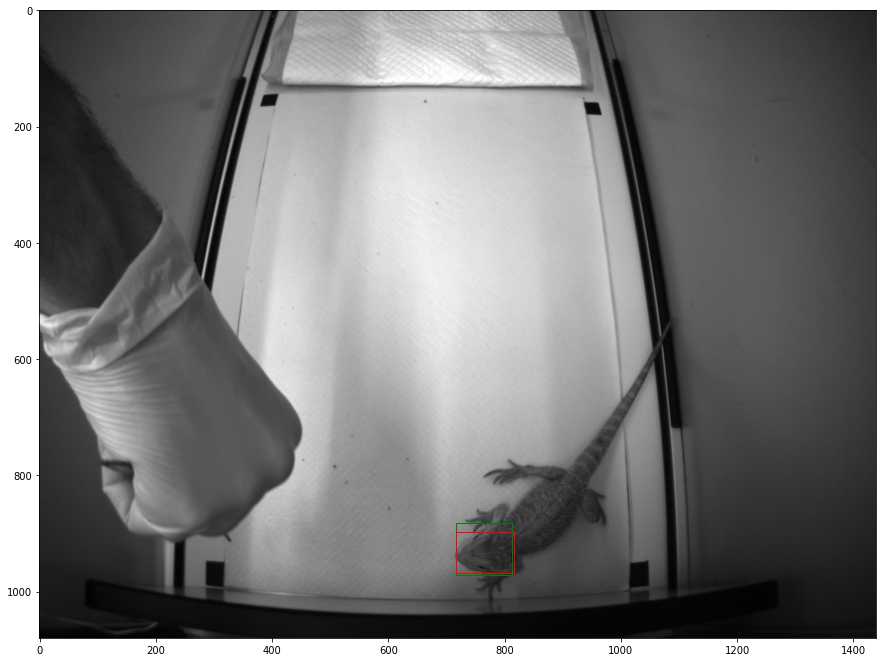

In [17]:
i = 5 * sorted_df.shape[0] // 100 + 1
plot_row(sorted_df.iloc[i])
plt.savefig(os.path.join(plots_dir, "per5_iou.jpg"))
print(f"{sorted_df.iloc[i].filename}: {sorted_df.iloc[i].IoU}")

### 95% Quantile Image

../yolo_eval_frames/line_20200803T094928_trial1_336.jpg: 0.9441712644679934


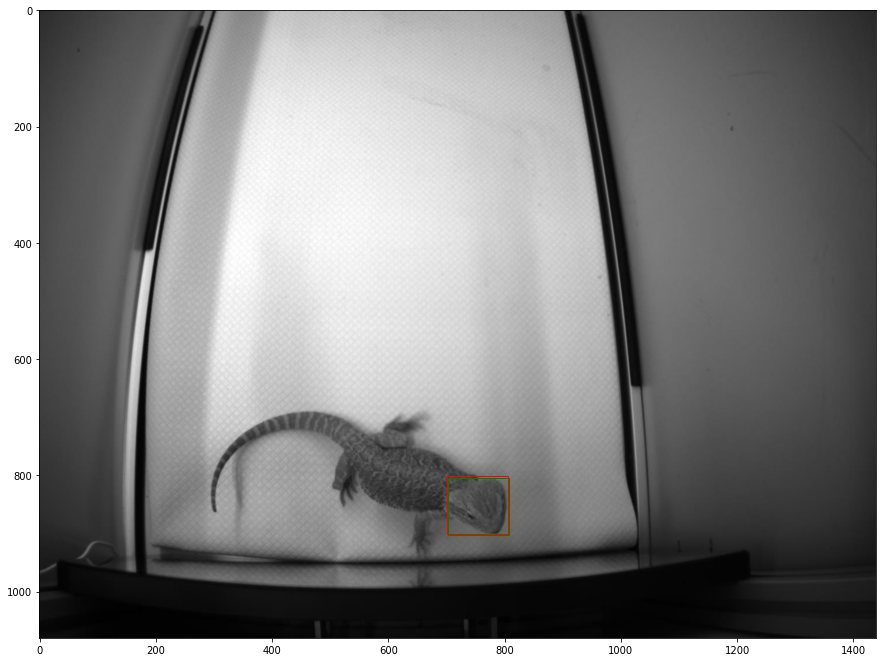

In [21]:
i = 95 * sorted_df.shape[0] // 100
plot_row(sorted_df.iloc[i])
plt.savefig(os.path.join(plots_dir, "per95_iou.jpg"))
print(f"{sorted_df.iloc[i].filename}: {sorted_df.iloc[i].IoU}")

### Median Image

../yolo_eval_frames/circle_20200803T115839_trial1_4744.jpg: 0.8676690103096533


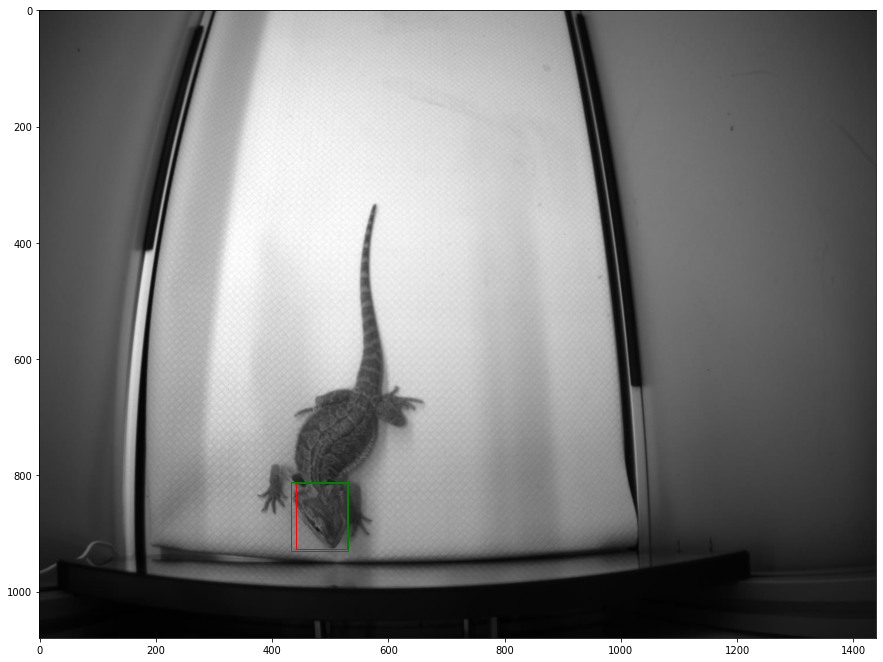

In [22]:
i = sorted_df.shape[0] // 2
plot_row(sorted_df.iloc[i])
plt.savefig(os.path.join(plots_dir, "median_iou.jpg"))
print(f"{sorted_df.iloc[i].filename}: {sorted_df.iloc[i].IoU}")

### IoU Quantiles

In [250]:
det_df['IoU'].quantile([0.01,0.05, 0.1, 0.25, .5, .75 ,.9])

0.01    0.702130
0.05    0.766707
0.10    0.795564
0.25    0.832656
0.50    0.867570
0.75    0.903400
0.90    0.930206
Name: IoU, dtype: float64

In [267]:
threshold = 0.80
percentile = det_df['IoU'][det_df['IoU'] > threshold].shape[0] / det_df.shape[0]
print(f"{percentile*100:.3f}% of the images have IoU above {threshold}")

88.512% of the images have IoU above 0.8


# False Negative Analysis

In [4]:
all_df = dataset.collect_data(data_sources={'detections': True, 'timestamps': True, 'dlc': False, 'touches': True})

110 trials loaded


In [5]:
nan_per_trial = [(trial, all_df.loc[trial].cent_x.isna().sum()) for trial in all_df.index.unique()]

In [6]:
trials_with_nans = [c for c in nan_per_trial if c[1]!=0]
trials_with_nans

[('feeding_20200830-120813_None', 3772),
 ('feeding_4_20200830-121143_None', 203),
 ('feeding_4_20200830-122515_None', 45),
 ('feeding_4_20200830-125531_None', 192),
 ('feeding_4_20200830-125905_None', 364),
 ('feeding_4_screen_20200830-130446_None', 1290),
 ('feeding_5_20200830-131348_None', 1453),
 ('circle_20200803T090234_trial1', 63),
 ('circle_20200803T090615_trial1', 4),
 ('line_20200803T094928_trial1', 8),
 ('line_20200803T101641_trial1', 797),
 ('circle_20200803T113121_trial1', 4),
 ('line_20200803T114942_trial1', 64),
 ('circle_20200803T115839_trial1', 4),
 ('circle_20200803T120911_trial1', 3),
 ('cockroach_line_20200830T120130_trial1', 1155),
 ('worm_line_20200830T121825_trial1', 6),
 ('always_reward_20200917T044011_trial1', 1034),
 ('learning_20200917T081521_trial1', 3134),
 ('learning_20200917T081521_trial3', 1383),
 ('learning_20200917T084025_trial1', 28),
 ('learning_20200917T092820_trial3', 1),
 ('learning_20200917T150415_trial2', 111),
 ('learning_20200917T154539_trial2

In [7]:
def nan_heatmap(trial, ax):
    nans = all_df.loc[trial].cent_x.isna().to_numpy().astype(float)
    sns.heatmap(nans.reshape(-1, 1).transpose(), ax=ax)

In [8]:
def nan_range(trial):
    nans = all_df.loc[trial].cent_x.isna().to_numpy()
    return np.argwhere(nans)[0], np.argwhere(nans)[-1], np.argwhere(~nans)[0], np.argwhere(~nans)[-1]

In [11]:
%matplotlib widget
# Make spacing work with title
fig, axs = plt.subplots(17, 1, figsize=(10, 15))
for ax, trial in zip(axs.reshape(-1), trials_with_nans):
    range = nan_range(trial[0])
    ax.set_title(trial)
    nan_heatmap(trial[0], ax)
    ax.plot([range[0], range[0]], [0, 1], c='g', linewidth=2)
    ax.plot([range[1], range[1]], [0, 1], c='g', linewidth=2)
    ax.plot([range[2], range[2]], [0, 1], c='r', linewidth=2)
    ax.plot([range[3], range[3]], [0, 1], c='r', linewidth=2)    

fig.tight_layout(pad=2.0)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

/home/user/miniconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  if sys.path[0] == '':


In [342]:
trials_low_nans = [t for t in trials_with_nans if t[1]<=200]
trials_high_nans = [t for t in trials_with_nans if t[1]>200]

In [349]:
trials_high_nans

[('feeding_20200830-120813_None', 3772),
 ('feeding_4_20200830-121143_None', 203),
 ('feeding_4_20200830-125905_None', 364),
 ('feeding_4_screen_20200830-130446_None', 1290),
 ('feeding_5_20200830-131348_None', 1453),
 ('line_20200803T101641_trial1', 797),
 ('cockroach_line_20200830T120130_trial1', 1155)]

In [344]:
nans_path = '../yolo_fn_frames'

In [348]:
for t, c in trials_low_nans:
    vid_path = dataset.get_trial_video_path(t)
    nans = all_df.loc[t].cent_x.isna().to_numpy()
    save_video_frames(vid_path, nans_path, t, np.argwhere(nans).reshape(-1))

In [352]:
[dataset.get_trial_video_path(t) for t, c in trials_high_nans]

['../../Pogona_Pursuit/Arena/output/feeding_20200830-120813/19506468.avi',
 '../../Pogona_Pursuit/Arena/output/feeding_4_20200830-121143/19506468.avi',
 '../../Pogona_Pursuit/Arena/output/feeding_4_20200830-125905/19506468.avi',
 '../../Pogona_Pursuit/Arena/output/feeding_4_screen_20200830-130446/19506468.avi',
 '../../Pogona_Pursuit/Arena/output/feeding_5_20200830-131348/19506468.avi',
 '../../Pogona_Pursuit/Arena/experiments/line_20200803T101641/trial1/videos/20200803-101641/19506468.avi',
 '../../Pogona_Pursuit/Arena/experiments/cockroach_line_20200830T120130/trial1/videos/20200830-120130/19506468.avi']

In [354]:
%matplotlib widget
fig, axs = plt.subplots(len(trials_high_nans), 1, figsize=(10, len(trials_high_nans)))
fig.tight_layout(pad=2.0)
for ax, trial in zip(axs.reshape(-1), trials_high_nans):
    range = nan_range(trial[0])
    nan_heamap(trial[0], ax)
    ax.plot([range[0], range[0]], [0, 1], c='g', linewidth=2)
    ax.plot([range[1], range[1]], [0, 1], c='g', linewidth=2)
    ax.plot([range[2], range[2]], [0, 1], c='r', linewidth=2)
    ax.plot([range[3], range[3]], [0, 1], c='r', linewidth=2)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [360]:
# special treatment for trials with many false negatives
nans_path_0 = '../yolo_fn_frames/feeding_20200830-120813_None'
t, c = trials_high_nans[0]
vid_path = dataset.get_trial_video_path(t)
nans = all_df.loc[t].cent_x.isna().to_numpy()[:-3000]
save_video_frames(vid_path, nans_path_0, t, np.argwhere(nans).reshape(-1))

In [359]:
np.argwhere(nans).reshape(-1).shape

(772,)

In [361]:
nans_path_1 = '../yolo_fn_frames/feeding_4_20200830-121143'
t, c = trials_high_nans[1]
vid_path = dataset.get_trial_video_path(t)
nans = all_df.loc[t].cent_x.isna().to_numpy()
save_video_frames(vid_path, nans_path_1, t, np.argwhere(nans).reshape(-1))

In [362]:
nans_path_2 = '../yolo_fn_frames/feeding_4_20200830-125905'
t, c = trials_high_nans[2]
vid_path = dataset.get_trial_video_path(t)
nans = all_df.loc[t].cent_x.isna().to_numpy()
save_video_frames(vid_path, nans_path_2, t, np.argwhere(nans).reshape(-1))

In [363]:
nans_path_3 = '../yolo_fn_frames/feeding_4_screen_20200830-130446'
t, c = trials_high_nans[3]
vid_path = dataset.get_trial_video_path(t)
nans = all_df.loc[t].cent_x.isna().to_numpy()
save_video_frames(vid_path, nans_path_3, t, np.argwhere(nans).reshape(-1))

In [364]:
nans_path_4 = '../yolo_fn_frames/feeding_5_20200830-131348'
t, c = trials_high_nans[4]
vid_path = dataset.get_trial_video_path(t)
nans = all_df.loc[t].cent_x.isna().to_numpy()
save_video_frames(vid_path, nans_path_4, t, np.argwhere(nans).reshape(-1))

In [365]:
nans_path_5 = '../yolo_fn_frames/line_20200803T101641_trial1'
t, c = trials_high_nans[5]
vid_path = dataset.get_trial_video_path(t)
nans = all_df.loc[t].cent_x.isna().to_numpy()
save_video_frames(vid_path, nans_path_5, t, np.argwhere(nans).reshape(-1))

In [366]:
nans_path_6 = '../yolo_fn_frames/cockroach_line_20200830T120130_trial1'
t, c = trials_high_nans[6]
vid_path = dataset.get_trial_video_path(t)
nans = all_df.loc[t].cent_x.isna().to_numpy()
save_video_frames(vid_path, nans_path_6, t, np.argwhere(nans).reshape(-1))

# Test Undetected Frames with Lower Confidence Threshold

- Replace this thing with a distribution of confidences by running detector with conf=0. nms can stay at 0.6

In [367]:
undetected_paths = glob('../yolo_fn_frames/*')

In [388]:
confs = np.arange(0.9, 0.1, -0.1)
nmss = np.concatenate((np.arange(0.6, 0.05, -0.1), np.array([0.1]*2)))

conf_df = pd.DataFrame()
conf_df['filename'] = undetected_paths
num_undetected = len(undetected_paths)

col = np.empty(num_undetected)

for conf, nms in zip(confs, nmss):    
    det.set_conf_and_nms(conf, nms)
    print(f"Set conf={conf}, nms={nms}")
    for i, path in enumerate(tqdm(undetected_paths)):
        img = cv.imread(path)
        ds = det.detect_image(img)
        col[i] = 0 if ds is None else ds.shape[0]
    conf_df[f'{conf}/{nms}'] = col
    num_detected = col[col > 0].shape[0]
    print(f"Detected {num_detected}/{num_undetected}")

    if num_detected == num_undetected:
        print("Found detections for all images. Breaking...")
        break

Set conf=0.9, nms=0.6



Detected 130/2768
Set conf=0.8, nms=0.5



Detected 1284/2768
Set conf=0.7000000000000001, nms=0.4



Detected 1807/2768
Set conf=0.6000000000000001, nms=0.30000000000000004



Detected 2116/2768
Set conf=0.5000000000000001, nms=0.20000000000000007



Detected 2320/2768
Set conf=0.40000000000000013, nms=0.10000000000000009



Detected 2497/2768
Set conf=0.30000000000000016, nms=0.1



Detected 2618/2768
Set conf=0.20000000000000018, nms=0.1



Detected 2706/2768


In [2]:
conf_df.columns

NameError: name 'conf_df' is not defined

In [394]:
conf_df = conf_df.rename(columns={"0.7000000000000001/0.4": "0.7/0.4", "0.6000000000000001/0.30000000000000004": "0.6/0.3", "0.40000000000000013/0.10000000000000009": "0.4/0.1",
                       "0.30000000000000016/0.1": "0.3/0.1", "0.20000000000000018/0.1": "0.2/0.1", "0.5000000000000001/0.20000000000000007": "0.5/0.2"})

In [400]:
multiple_dets = {}

for col in conf_df.columns:
    if col == 'filename': continue
    c = conf_df[col]
    multiple_dets[col] = c[c > 1.0].shape[0]
    
multiple_dets

{'0.9/0.6': 0,
 '0.8/0.5': 0,
 '0.7/0.4': 0,
 '0.6/0.3': 0,
 '0.5/0.2': 0,
 '0.4/0.1': 0,
 '0.3/0.1': 0,
 '0.2/0.1': 0}

In [430]:
def plot_sample_conf(pos_col, neg_col, n):
    # find all images that had no detections in neg_col and had detections in pos_col
    pos = conf_df[pos_col] > 0.0
    neg = conf_df[neg_col] == 0.0
    matches = conf_df['filename'][pos & neg].to_numpy()
    sample = np.random.choice(matches, n, replace=False)
    print(sample)
    cols = 3
    rows = int(np.ceil(n/cols))
    fig, axs = plt.subplots(rows, cols, figsize=(10, rows*3))
    for path, ax in zip(sample, axs.reshape(-1)):
        img = cv.imread(path)
        conf, nms = [float(s) for s in pos_col.split('/')]
        det.set_conf_and_nms(conf, nms)
        x1, y1, x2, y2, _ = det.detect_image(img)[0]
        ax.imshow(img)
        ax.add_patch(patches.Rectangle((x1,y1),x2-x1, y2-y1,linewidth=1,edgecolor='r',facecolor='none'))

In [439]:
plot_sample_conf("0.2/0.1", "0.3/0.1", 20)

['../yolo_fn_frames/line_20200803T101641_trial1_4550.jpg'
 '../yolo_fn_frames/cockroach_line_20200830T120130_trial1_536.jpg'
 '../yolo_fn_frames/cockroach_line_20200830T120130_trial1_929.jpg'
 '../yolo_fn_frames/cockroach_line_20200830T120130_trial1_775.jpg'
 '../yolo_fn_frames/feeding_4_screen_20200830-130446_None_2769.jpg'
 '../yolo_fn_frames/feeding_4_screen_20200830-130446_None_2715.jpg'
 '../yolo_fn_frames/feeding_4_screen_20200830-130446_None_2664.jpg'
 '../yolo_fn_frames/feeding_4_screen_20200830-130446_None_2690.jpg'
 '../yolo_fn_frames/cockroach_line_20200830T120130_trial1_667.jpg'
 '../yolo_fn_frames/line_20200803T101641_trial1_298.jpg'
 '../yolo_fn_frames/cockroach_line_20200830T120130_trial1_552.jpg'
 '../yolo_fn_frames/cockroach_line_20200830T120130_trial1_838.jpg'
 '../yolo_fn_frames/feeding_4_screen_20200830-130446_None_2689.jpg'
 '../yolo_fn_frames/feeding_4_screen_20200830-130446_None_2703.jpg'
 '../yolo_fn_frames/cockroach_line_20200830T120130_trial1_756.jpg'
 '../yol

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

### Results:
- as far as I can tell, 0.8/0.5 gives good detections. Consider lowering the default.
- 0.7/0.4 gives reasonable detections as well. Some bboxes were not so good ('../yolo_fn_frames/feeding_4_screen_20200830-130446_None_2616.jpg')
- 0.6/0.3 and 0.5/0.2 looks very similar to the previous one. Bad examples:
    - '../yolo_fn_frames/feeding_4_20200830-121143_None_396.jpg'
    - '../yolo_fn_frames/feeding_4_screen_20200830-130446_None_2654.jpg'
- 0.4/0.1 looks pretty much the same. New arrival: '../yolo_fn_frames/feeding_4_screen_20200830-130446_None_6066.jpg'
- It keeps going the same way.

### Conclusion:
- With 0.9/0.6 we have 2638/249771 = ~1% false negatives.
- With 0.8/0.5 we go down to 1484/249771 = ~0.6% false negatives.
- Out of these 1484 there were actually ~350 unique frames (the pogona froze in an undetected pose for a long time). Many failures occurred because there were multiple objects in the frame (such as Itai's hand).
- We should consider lowering the confidence to 0.8/0.5. We could lower it even more but we might have false positives.
- It's probable that adding these images to the training dataset will result in better results.